<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>A1: Unsupervised Analysis Project</h2>
<br>Kimberly Batin<br>

<br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Introduction</h2><br>

Social media evolves very quick, catching up and updating the tactics never stop. Understanding the dynamics of user engagement across various content types is crucial for content creators, business owners, and marketers alike. Among the content types available, photos have traditionally been regarded as one of the most engaging forms of media on platforms like Facebook, Instagram, and Twitter. This study aim to investigate the impact of photo content on user engagement in the context of Facebook Live sellers in Thailand. Photos have been traditionally regarded as highly engaging content. This study will verify the accuracy of this belief by comparing the engagement metrics of photos to other forms of content such as videos and text posts.

This analysis will also give an idea on recent trends in user behavior and engagement. The findings of this analysis could inform content strategies, helping brands and small businesses optimize their posts to better suit the preferences of their audiences. Through a combination of data aggregation, visual analysis, and model testing, the analyst aims to provide a comprehensive overview of the current state of Facebook engagement.


<h2> Import Libraries and Preparation </h2>

In [1]:
########################################
# importing packages
########################################
import numpy                 as np  # mathematical essentials
import pandas                as pd  # data science essentials
import matplotlib.pyplot     as plt # fundamental data visualization
import seaborn               as sns # enhanced visualizations

# packages for unsupervised learning
from sklearn.preprocessing   import StandardScaler      # standard scaler
from sklearn.decomposition   import PCA                 # pca
from scipy.cluster.hierarchy import dendrogram, linkage # dendrograms
from sklearn.cluster         import KMeans              # k-means clustering
from sklearn.model_selection import train_test_split        # train-test split
from sklearn.metrics import confusion_matrix, roc_auc_score # results analysis
from sklearn.cluster import KMeans                          # k-means clustering
import sklearn.linear_model                                 # classification modeling

########################################
# loading data and setting display options
########################################
# loading data
facebook = pd.read_excel(io = '/Users/kimberly/Desktop/AI - A1/facebook_live_data.xlsx')


# setting print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

facebook.head(n = 5)

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,photo,2023-07-04 22:45:00,0,0,150,0,0,0,0,0
1,2,photo,2023-06-23 01:01:00,2,3,202,7,1,0,0,0
2,3,photo,2023-06-21 02:23:00,4,0,200,8,1,0,0,0
3,4,video,2023-06-14 05:16:00,100,30,303,23,1,5,0,0
4,5,video,2023-06-08 08:28:00,173,47,132,16,1,0,1,0


In [2]:
########################################
# scree_plot
########################################
def scree_plot(pca_object, export = False):
    """
    Visualizes a scree plot from a pca object.
    
    PARAMETERS
    ----------
    pca_object | A fitted pca object
    export     | Set to True if you would like to save the scree plot to the
               | current working directory (default: False)
    """
    # building a scree plot

    # setting plot size
    fig, ax = plt.subplots(figsize=(10, 8))
    features = range(pca_object.n_components_)


    # developing a scree plot
    plt.plot(features,
             pca_object.explained_variance_ratio_,
             linewidth = 2,
             marker = 'o',
             markersize = 10,
             markeredgecolor = 'black',
             markerfacecolor = 'grey')


    # setting more plot options
    plt.title('Scree Plot')
    plt.xlabel('PCA feature')
    plt.ylabel('Explained Variance')
    plt.xticks(features)

    if export == True:
    
        # exporting the plot
        plt.savefig('./analysis_images/top_customers_correlation_scree_plot.png')
        
    # displaying the plot
    plt.show()


########################################
# unsupervised_scaler
########################################
def scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

In [3]:
# checking information about each column
facebook.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   status_id       2362 non-null   int64         
 1   status_type     2362 non-null   object        
 2   time_published  2362 non-null   datetime64[ns]
 3   num_comments    2362 non-null   int64         
 4   num_shares      2362 non-null   int64         
 5   num_likes       2362 non-null   int64         
 6   num_loves       2362 non-null   int64         
 7   num_wows        2362 non-null   int64         
 8   num_hahas       2362 non-null   int64         
 9   num_sads        2362 non-null   int64         
 10  num_angrys      2362 non-null   int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 203.1+ KB


In [4]:
# descriptive statistics about each numeric column
facebook.describe(include = 'number').round(decimals = 2)

,status_id,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00
mean,1181.50,233.73,39.82,221.15,12.83,1.28,0.74,0.26,0.12
std,681.99,856.36,123.78,467.31,41.00,8.72,4.11,1.84,0.90
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,591.25,0.00,0.00,17.00,0.00,0.00,0.00,0.00,0.00
50%,1181.50,4.00,0.00,57.00,0.00,0.00,0.00,0.00,0.00
75%,1771.75,23.00,3.00,186.00,3.00,0.00,0.00,0.00,0.00
max,2362.00,10960.00,1260.00,4315.00,421.00,278.00,102.00,46.00,31.00


In [5]:
# value counts for channel and region
print(f"""\
Status Type
-------
{facebook['status_type'].value_counts(normalize=False).to_string(buf=None)}
""")

Status Type
-------
status_type
photo    1443
video     763
text      156



<h3> Visualization </h3>

In [6]:
# Extracting year from the 'time_published' column
facebook['year'] = facebook['time_published'].dt.year

# Creating one-hot encoded variables for each year
year_dummies = pd.get_dummies(facebook['year'], prefix='year')

# Concatenating these new columns to the original dataframe
facebook = pd.concat([facebook, year_dummies], axis=1)

facebook['year_2017'] = facebook['year_2017'].astype(int)
facebook['year_2019'] = facebook['year_2019'].astype(int)
facebook['year_2020'] = facebook['year_2020'].astype(int)
facebook['year_2023'] = facebook['year_2023'].astype(int)

In [7]:
# Filter for the year
data_2017 = facebook[facebook['year'] == 2017]
data_2019 = facebook[facebook['year'] == 2019]
data_2020 = facebook[facebook['year'] == 2020]
data_2023 = facebook[facebook['year'] == 2023]


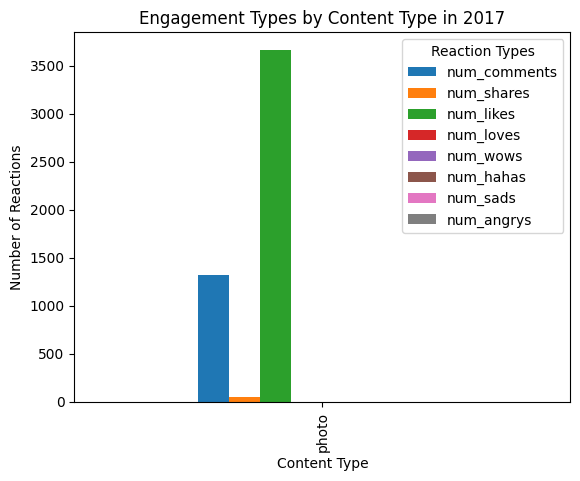

In [8]:
# including columns for the graph
reacts = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 
                  'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

engagement_2017 = data_2017.groupby('status_type')[reacts].sum()

# Plotting a bar chart for the summed engagement metrics
engagement_2017.plot(kind='bar', stacked=False)
plt.title('Engagement Types by Content Type in 2017')
plt.xlabel('Content Type')
plt.ylabel('Number of Reactions')
plt.legend(title='Reaction Types')
plt.show()

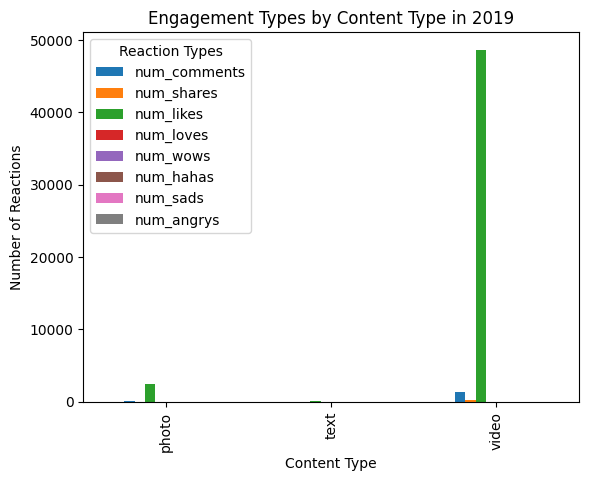

In [9]:
# including columns for the graph
reacts = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 
                  'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

engagement_2019 = data_2019.groupby('status_type')[reacts].sum()

# Plotting a bar chart for the summed engagement metrics
engagement_2019.plot(kind='bar', stacked=False)
plt.title('Engagement Types by Content Type in 2019')
plt.xlabel('Content Type')
plt.ylabel('Number of Reactions')
plt.legend(title='Reaction Types')
plt.show()

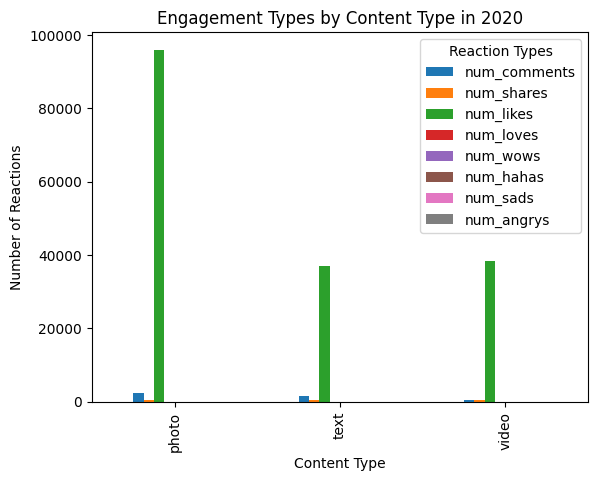

In [10]:
# including columns for the graph
reacts = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 
                  'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

engagement_2020 = data_2020.groupby('status_type')[reacts].sum()

# Plotting a bar chart for the summed engagement metrics
engagement_2020.plot(kind='bar', stacked=False)
plt.title('Engagement Types by Content Type in 2020')
plt.xlabel('Content Type')
plt.ylabel('Number of Reactions')
plt.legend(title='Reaction Types')
plt.show()

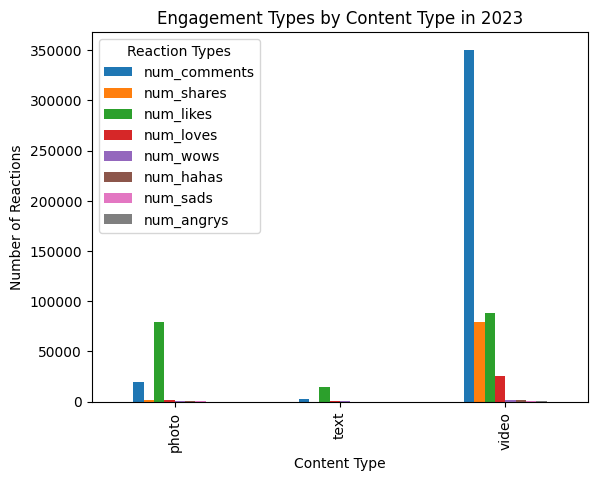

In [11]:
# including columns for the graph
reacts = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 
                  'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

engagement_2023 = data_2023.groupby('status_type')[reacts].sum()

# Plotting a bar chart for the summed engagement metrics
engagement_2023.plot(kind='bar', stacked=False)
plt.title('Engagement Types by Content Type in 2023')
plt.xlabel('Content Type')
plt.ylabel('Number of Reactions')
plt.legend(title='Reaction Types')
plt.show()

The analyst created four charts for the years 2017, 2019, 2020, and 2023. These were created to analyze trends from the earliest year in the dataset (2017), to understand Facebook post engagement before the pandemic (2019), to examine data at the peak of the pandemic (2020), and to assess recent trends (2023).

In 2017, the data consisted only of photos as the content type. According to a 2017 BCG article, Thailand had developed a social media model for online sales. Social media commerce accounted for more than 40% of online sales in categories such as phones and accessories, cosmetics, and clothing, indicating that online selling was significant that year. It can also be perceived that photos posted likely included images of products, along with prices and available sizes either on the photo itself or in the captions.

The analyst was curious in the data of 2019, because she wants to see the trend or behavior of the engagements on Facebook before the pandemic. In the given data, it is obvious that video content has more engagement than the photo. Norcross (2019) wrote that the video content earned the largest audience engagement rate on Facebook, followed by photo-based posts. Facebook Messenger was the most downloaded application for mobile phones in Thailand, with Facebook itself in third place. It can be inferred that people direct to Messenger instead of engaging through the photo posts.

In 2020, photos garnered more engagement than videos and texts. The analyst hypothesizes that the lower video engagement might be due to people staying at home, where creating live content typically requires a team. Zhenhub (2020) discussed how eCommerce platforms are attracted to Thailand's expanding online shopping sector. Business owners have launched online stores across various marketplaces to cater to local demands, selling on platforms like Lazada and Shopee. This trend supports the analyst's assumption that photos performed better, because sellers uploaded more photos.

Live Selling was more popular than other content types in 2023. Live streaming engagement has been one of the main drivers of ecommerce. Due to the evolution of social media, buyer have been more meticulous in choosing the products they are purchasing. Sellers can showcase their products in real-time, provide product details and payment options and interact with existing and potential customers directly from their live broadcast. Buying from a live seller is like buying from malls but in a more convenient way.


In [12]:
# dropping these features. i just used it for Question 2 purposes
facebook = facebook.drop(labels   = ['year', 'year_2017', 'year_2018', 'year_2019', 
                                     'year_2020', 'year_2021', 'year_2022', 'year_2023'],
                       axis   = 1)

/Users/kimberly/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kimberly/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kimberly/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kimberly/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance

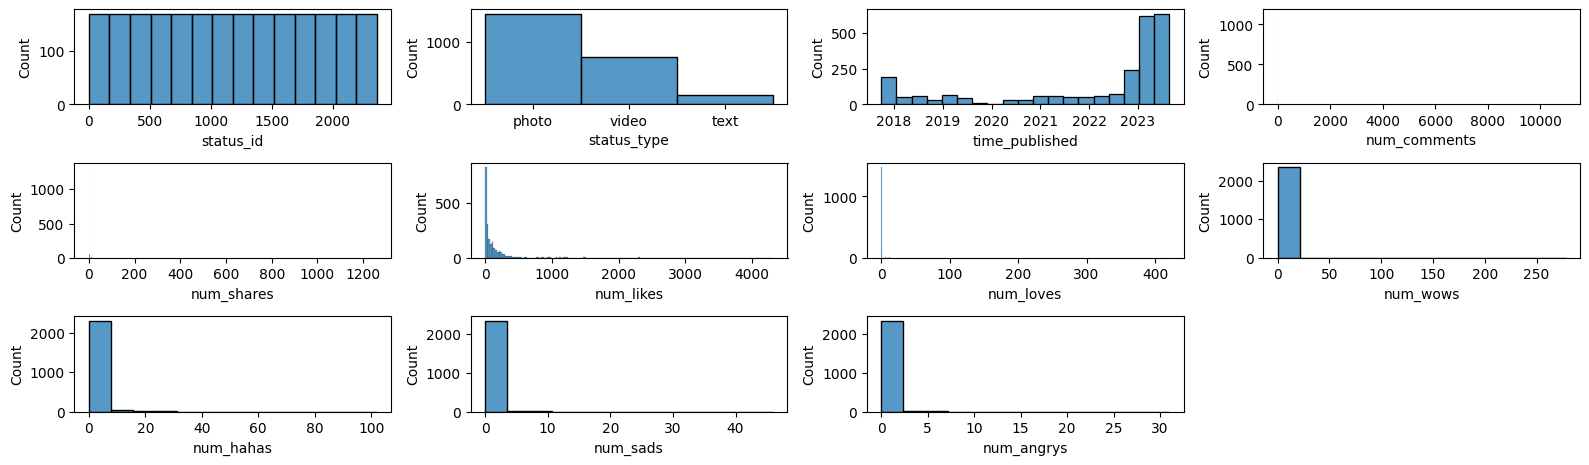

In [13]:
# setting figure size
fig, ax = plt.subplots(figsize = (16, 12))
ax.remove()

# initializing a counter
count = 0


# looping to create visualizations
for col in facebook:

    # condition to break
    if count == 30:
        break
    
    # increasing count
    count += 1
    
    # preparing histograms
    plt.subplot(8, 4, count)
    sns.histplot(x = facebook[col],)


# formatting, saving, and displaying the plot
plt.tight_layout()
plt.show()

<h3> Scaling </h3>

In [14]:
# dropping demographic information
facebook = facebook.drop(['status_id', 'status_type', 'time_published'],
                                      axis = 1)

# scaling (normalizing) variables before correlation analysis
fb_scaled = scaler(df = facebook)


# checking pre- and post-scaling variance
print(np.var(facebook), '\n\n')
print(np.var(fb_scaled))

num_comments    733040.526533
num_shares       15315.110634
num_likes       218288.813477
num_loves         1680.086166
num_wows            75.978259
num_hahas           16.896863
num_sads             3.392409
num_angrys           0.817271
dtype: float64 


num_comments    1.0
num_shares      1.0
num_likes       1.0
num_loves       1.0
num_wows        1.0
num_hahas       1.0
num_sads        1.0
num_angrys      1.0
dtype: float64


/Users/kimberly/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3745: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


<h2> Principal Component Analysis </h2>

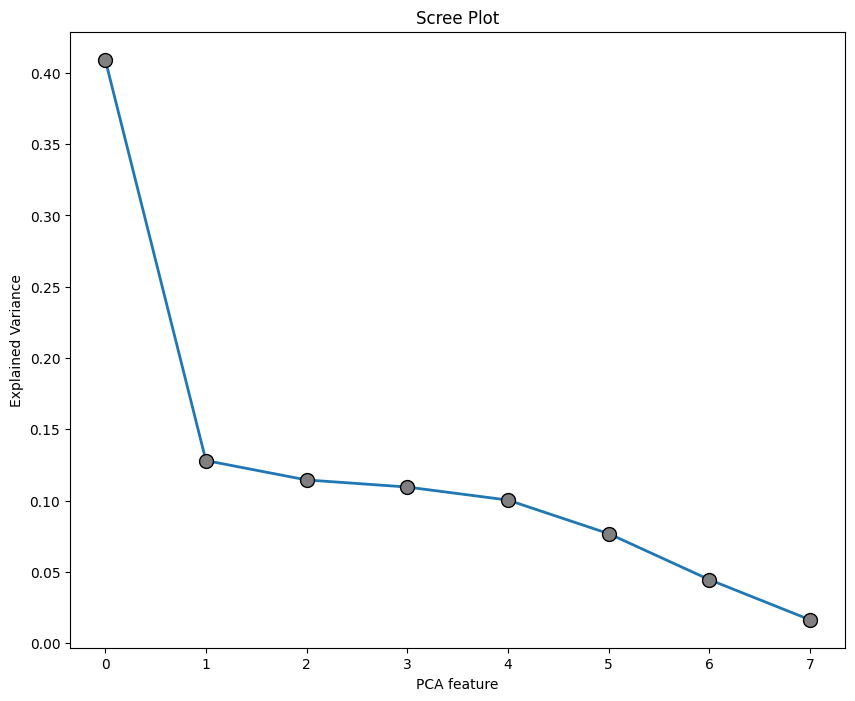

In [15]:
# INSTANTIATING a PCA object with no limit to principal components
pca = PCA(n_components = None,
          random_state = 702)


# FITTING and TRANSFORMING the purchases_scaled
fb_pca = pca.fit_transform(fb_scaled)


# calling the scree_plot function
scree_plot(pca_object = pca)

In [16]:
# INSTANTIATING a new model using the first two principal components
pca_2 = PCA(n_components = 2,
            random_state = 702)


# FITTING and TRANSFORMING the purchases_scaled
customer_pca_2 = pca_2.fit_transform(fb_scaled)

# tried to retain three, just to see the result

In [17]:
####################
### Max PC Model ###
####################
# transposing pca components (pc = MAX)
factor_loadings = pd.DataFrame(np.transpose(pca.components_))


# naming rows as original features
factor_loadings = factor_loadings.set_index(fb_scaled.columns)


##################
### 2 PC Model ###
##################
# transposing pca components (pc = 3)
factor_loadings_2 = pd.DataFrame(np.transpose(pca_2.components_))


# naming rows as original features
factor_loadings_2 = factor_loadings_2.set_index(fb_scaled.columns)


# checking the results
print(f"""
MAX Components Factor Loadings
------------------------------
{factor_loadings.round(2)}


2 Components Factor Loadings
------------------------------
{factor_loadings_2.round(2)}
""")


MAX Components Factor Loadings
------------------------------
                 0     1     2     3     4     5     6     7
num_comments  0.41 -0.31 -0.03 -0.20 -0.39 -0.18  0.67 -0.24
num_shares    0.49 -0.12  0.05 -0.17 -0.21 -0.22 -0.33  0.71
num_likes     0.16  0.73 -0.35  0.25 -0.49  0.11  0.05  0.00
num_loves     0.50  0.00  0.06 -0.08  0.01 -0.06 -0.56 -0.65
num_wows      0.30  0.48  0.08 -0.08  0.64 -0.42  0.29  0.04
num_hahas     0.37  0.01 -0.05 -0.20  0.28  0.84  0.14  0.12
num_sads      0.20 -0.35 -0.68  0.54  0.27 -0.09 -0.01  0.03
num_angrys    0.22 -0.04  0.63  0.72 -0.04  0.11  0.11  0.04


2 Components Factor Loadings
------------------------------
                 0     1
num_comments  0.41 -0.31
num_shares    0.49 -0.12
num_likes     0.16  0.73
num_loves     0.50  0.00
num_wows      0.30  0.48
num_hahas     0.37  0.01
num_sads      0.20 -0.35
num_angrys    0.22 -0.04



In [18]:
# naming each principal component
factor_loadings_2.columns = ['Engagement', 
                             'Reacts',     
                             ]  


# checking the result
factor_loadings_2.round(decimals = 2)

,Engagement,Reacts
num_comments,0.41,-0.31
num_shares,0.49,-0.12
num_likes,0.16,0.73
num_loves,0.50,0.00
num_wows,0.30,0.48
num_hahas,0.37,0.01
num_sads,0.20,-0.35
num_angrys,0.22,-0.04


<h4> Develop a scree plot and determine how many principal components you would like to retain. Draw a vertical line in the scree plot to indicate your cutoff point. Explain your rationale. (minimum 5 sentences)
    
Interpret each of your retained principal components. Remember to interpret both sides of each principal component. (minimum 5 sentences per principal component)</h4>

By narrowing the data down to two components, the analysis could be simplified by reducing the dimensions of the dataset which can be useful with the large number of metrics. The first two principal components usually capture the most significant variance within the dataset. It is likely to emphasize the most critical engagement trends in the data.

Suppose the first 2 principal components represent significant engagement actions like likes and shares, it can indicate that focusing on increasing these specific reactions could have the most impact on overall engagement for photos. Understanding which types of engagement are most significant for photo content can help tailor campaigns. Businesses can time their content releases to align with different patterns, posting certain types of photo content when it's most likely to receive the desired engagement.

First Principal likely captures the most common  pattern of engagement across all Facebook posts. It may indicate that photos are among the most engaging content types, it might be heavily influenced by the metrics associated with photos. The largest loadings are for num_shares, num_loves, and num_comments, suggesting this component may represent overall engagement, hence the name 'Engagement'. If it represents overall engagement, strategies that aim to increase general reactions like shares and loves should be prioritized. If sellers are seeking to boost overall engagement, focus on factors contributing to the First Principal.


Second Principal might represent the variance in how much content is shared. The analyst chose to only have 2 components as she believes these are the most informative. It has a high positive loading with num_likes and moderate with num_wows, which could be interpreted as a measure of positive sentiment, that's why it's 'Reacts'. The content that receives many likes should be emphasized. Posts with high 'likes' might be considered as appealing or attractive, prompting a quick and positive reaction from users. Posts that are enjoyable or positive often garners a lot of likes, as users can express their approval with a simple click.  A negative loading for 'num_comments' might imply that content with many likes does not necessarily provoke a lot of comments.


 In the Third Principal, it was not included because it did not give the analyst enough information to interpret. It can have a good insight, but the analyst decided not to include it. It is still worth to mention that num_sads has a strong negative loading in the Third Principal, this might represent that this reactions are less frequent. 

The analyst also tried to do 3 components in the first try but it seems that it did not make a difference.

In [19]:
# analyzing factor strengths per customer
factor_loadings = pca_2.transform(fb_scaled)


# converting to a DataFrame
factor_loadings_df = pd.DataFrame(factor_loadings)


# renaming columns
factor_loadings_df.columns = factor_loadings_2.columns


# checking the results
factor_loadings_df.head(n = 5)

,Engagement,Reacts
0,-0.619670,-0.006476
1,-0.469623,0.126667
2,-0.469004,0.125796
3,0.367677,0.240069
4,-0.019679,-0.278149


<h2> Intro to Clustering </h2>

In [20]:
# checking variance amongst clusters
np.var(factor_loadings_df)

/Users/kimberly/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3745: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Engagement    3.273609
Reacts        1.025052
dtype: float64

In [21]:
# applying the unsupervised_scaler function
pca_rescaled = scaler(df = factor_loadings_df)


# checking pre- and post-scaling variance
print(np.var(factor_loadings_df), '\n\n')
print(np.var(pca_rescaled))

Engagement    3.273609
Reacts        1.025052
dtype: float64 


Engagement    1.0
Reacts        1.0
dtype: float64


/Users/kimberly/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3745: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


<h2>Agglomerative Clustering</h2>

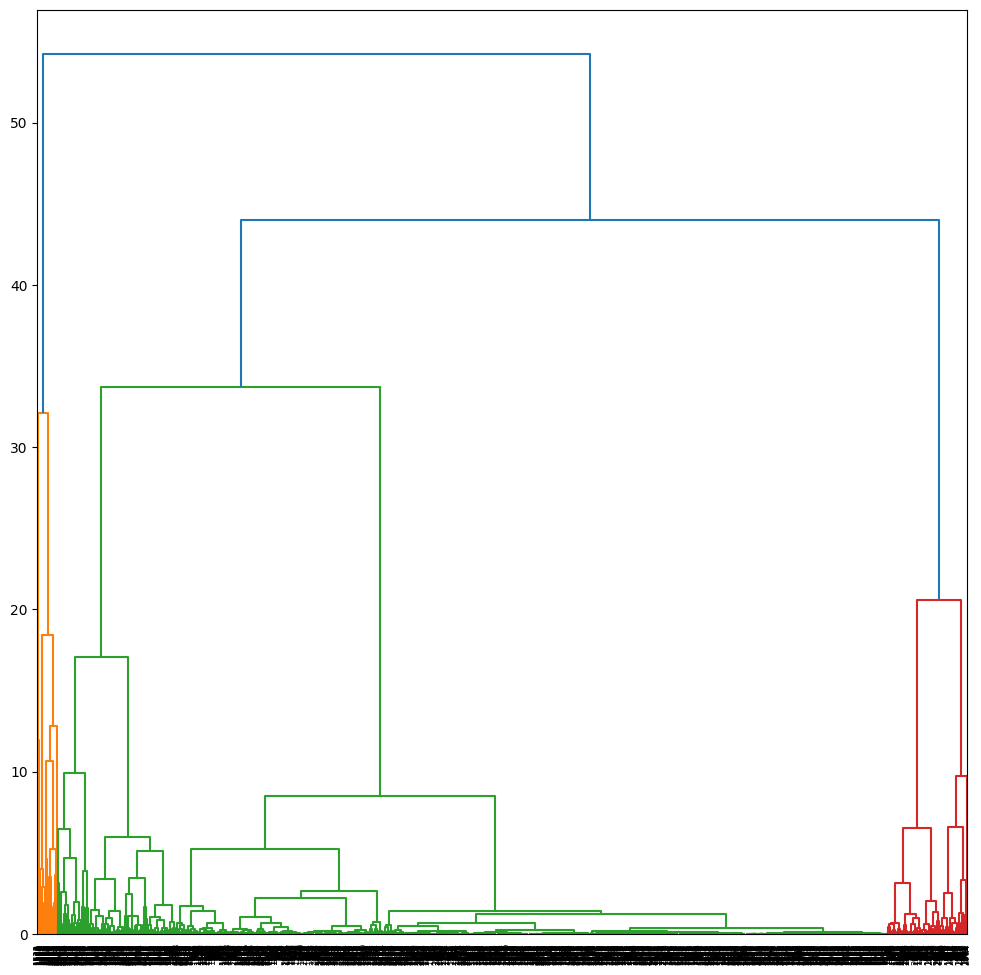

In [22]:
# grouping data based on Ward distance
standard_mergings_ward = linkage(y = pca_rescaled,
                                 method = 'ward',
                                 optimal_ordering = True)


# setting plot size
fig, ax = plt.subplots(figsize=(12, 12))

# developing a dendrogram
dendrogram(Z = standard_mergings_ward,
           leaf_rotation  = 90       ,
           leaf_font_size = 6        )


# rendering the plot
plt.show()

In [23]:
# INSTANTIATING a k-Means object with clusters
fb_k_pca = KMeans(n_clusters   = 2     ,
                         n_init       = 'auto',
                         random_state = 702   )


# fitting the object to the data
fb_k_pca.fit(pca_rescaled)


# converting the clusters to a DataFrame
fb_kmeans_pca = pd.DataFrame({'Cluster': fb_k_pca.labels_})


# checking the results
print(fb_kmeans_pca.iloc[: , 0].value_counts())

Cluster
1    2206
0     156
Name: count, dtype: int64


In [24]:
# storing cluster centers
centroids_pca = fb_k_pca.cluster_centers_


# converting cluster centers into a DataFrame
centroids_pca_df = pd.DataFrame(centroids_pca).round(decimals = 2)


# renaming principal components
centroids_pca_df.columns = ['Engagement', 
                             'Reacts',     
                             ]


# checking results (clusters = rows, pc = columns)
centroids_pca_df

,Engagement,Reacts
0,1.18,2.65
1,-0.08,-0.19


In [25]:
# i kept on experiencing error whenever i run all of these, whether manually or through run all. 
# so, to avoid experiencing the error, i am running this again
facebook = pd.read_excel(io = '/Users/kimberly/Desktop/AI - A1/facebook_live_data.xlsx')

In [26]:
# concatenating cluster memberships with principal components
clst_pca_df = pd.concat([fb_kmeans_pca,
                         factor_loadings_df],
                         axis = 1)


# concatenating demographic information with pca-clusters
final_df = pd.concat([facebook.loc[ : , ['status_id', 'status_type', 'time_published']],
                      clst_pca_df.round(decimals = 2)],
                      axis = 1)


# renaming columns
final_df.columns = ['status_id', 'status_type', 'time_published', 'Cluster',
                    'Engagement', 
                             'Reacts']


# checking the results
print(final_df.head(n = 5))

   status_id status_type      time_published  Cluster  Engagement  Reacts
0          1       photo 2023-07-04 22:45:00        1       -0.62   -0.01
1          2       photo 2023-06-23 01:01:00        1       -0.47    0.13
2          3       photo 2023-06-21 02:23:00        1       -0.47    0.13
3          4       video 2023-06-14 05:16:00        1        0.37    0.24
4          5       video 2023-06-08 08:28:00        1       -0.02   -0.28


In [27]:
# Count the number of each status type within each cluster
status_counts = final_df.groupby(['Cluster', 'status_type']).size().reset_index(name='counts')

status_counts

,Cluster,status_type,counts
0,0,photo,72
1,0,text,26
2,0,video,58
3,1,photo,1371
4,1,text,130
5,1,video,705


<h4> Decide on an ideal number of clusters and explain your rationale. (minimum 5 sentences)

Present and interpret each segment using cluster centroids and give an example of a "normal" post for each segment. (minimum 5 sentences per segment)

Analyze the status types of each segment and report any findings related to photos. (minimum 5 sentences)
</h4>

Understanding the difference of Cluster 0 from Cluster 1 could provide strategic insights into content creation. Most of the data points (2,206) fall into Cluster 1, while a smaller number (156) fall into Cluster 0. This suggests Cluster 1 has major segment and has potentially more niche, while Cluster 0 is an outlier segment. The values in centroids_pca_df represent the average location of each cluster by principal components. Cluster 0 has high values for both 'Engagement' and 'Reacts', which suggests that it captures posts with high engagement metrics, while Cluster 1 has lower values. With the time_published column, it can be seen when posts from each cluster were published. This potentially finds temporal patterns. The 'Engagement' and 'Reacts' columns are now associated with each original data point, wherein posts score higher on these components. 

In Cluster 0, it can be seen that this cluster has a higher proportion of 'photo' status types compared to Cluster 1. With its high 'Engagement' and 'Reacts', could represent a target group for highly engaging content. Given its smaller size, it might include content that is viral. Posts in this cluster are associated with higher overall engagement and stronger reactions from the audience. The posts are likely to stand out in users' feeds and may benefit from increased visibility due to Facebook's algorithms favoring content with high engagement. The content here can be of any type, photo, video, or text, but is distinguished by its ability to draw attention and provoke reactions. A "normal" post in this cluster might be a visually striking photo of a major current event that resonates with a large audience. The photo could be accompanied by a compelling caption that encourages sharing and discussion, leading to a high number of 'likes', 'shares', and comments. This post would likely perform well in terms of organic reach and possibly go viral. This post can be a seller's achievement or a seller's POV or BTS. 

In Cluster 1, the photos might have less representation or show a lower engagement score. It might indicate that while photos are common, they do not always guarantee high engagement. Cluster 1 could represent the 'normal' content engagement, which is where most content falls. With lower centroid values for 'Engagement' and 'Reacts', this captures typical engagement pattern for Facebook posts. These posts probably do not evoke strong emotional reactions, leading to a more moderate level of engagement. The content in this cluster might be more routine or expected. This cluster represents the bulk of content, forming the foundational engagement behavior on the platform. A "normal" post in Cluster 1 might be a standard photo update from the brand with a simple caption. It receives a modest amount of 'likes' and a few 'shares' from loyal followers but doesn't spark significant discussion or emotional reaction. This kind of post maintains a steady presence on the platform and keeps followers informed but is less likely to break through to wider audiences or go viral. This post can be the products that they are selling. These photos will be searched up by the potential buyers later on.

Having more clusters could capture the differences better. There might subgroups within the clusters that have different behaviors or characteristics, more clusters could be justified. Since this is about Facebook live selling, decisions or strategies can be neatly divided into two groups. Which posts have better engagements? Which posts need to have boost? Since the 2023 data shows more people engage in videos, seller should focus on betterment of their live selling. In this case, it does not only imply to just do live selling. Photo uploads still works. There is no big issue on why these photos were not 'liked' or 'love' by the followers. It does not give a lot of engagement, but it was never shown how the seller's direct messages look like. Maybe the inbox is full of inquiries from potential buyers. This can be a reminder to sellers to inform their audience that they've uploaded photos with prices and available sizes. Two clusters can lead to simpler and more actionable insights, and adding a third cluster might not add value and could complicate the strategy.

<h2>Analysis</h2>

<h3> Creating New Features </h3>

In [28]:
# Creating 'hour_of_day' feature
final_df['hour_of_day'] = final_df['time_published'].dt.hour

# Categorizing 'hour_of_day' into time segments
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

final_df['time_of_day'] = final_df['hour_of_day'].apply(categorize_hour)

    
# Use Pandas get_dummies to create one-hot encoded variables
time_of_day_dummies = pd.get_dummies(final_df['time_of_day'], prefix='time')

# Concatenate these new columns to the original dataframe
final_df = pd.concat([final_df, time_of_day_dummies], axis=1)

# Converting boolean columns to integer columns
final_df['time_Afternoon'] = final_df['time_Afternoon'].astype(int)
final_df['time_Evening'] = final_df['time_Evening'].astype(int)
final_df['time_Morning'] = final_df['time_Morning'].astype(int)
final_df['time_Night'] = final_df['time_Night'].astype(int)



# Creating 'day_of_week' feature (0=Monday, 6=Sunday)
final_df['day_of_week'] = final_df['time_published'].dt.dayofweek


# Extracting year and month from the 'time_published' column
final_df['year'] = final_df['time_published'].dt.year
final_df['month'] = final_df['time_published'].dt.month

# Creating one-hot encoded variables for each year
year_dummies = pd.get_dummies(final_df['year'], prefix='year')

# Concatenating these new columns to the original dataframe
final_df = pd.concat([final_df, year_dummies], axis=1)

final_df['year_2017'] = final_df['year_2017'].astype(int)
final_df['year_2018'] = final_df['year_2018'].astype(int)
final_df['year_2019'] = final_df['year_2019'].astype(int)
final_df['year_2020'] = final_df['year_2020'].astype(int)
final_df['year_2021'] = final_df['year_2021'].astype(int)
final_df['year_2022'] = final_df['year_2022'].astype(int)
final_df['year_2023'] = final_df['year_2023'].astype(int)


# Creating one-hot encoded variables for each month
month_dummies = pd.get_dummies(final_df['month'], prefix='month')

# Concatenating these new columns to the original dataframe
final_df = pd.concat([final_df, month_dummies], axis=1)

final_df['month_1'] = final_df['month_1'].astype(int)
final_df['month_2'] = final_df['month_2'].astype(int)
final_df['month_3'] = final_df['month_3'].astype(int)
final_df['month_4'] = final_df['month_4'].astype(int)
final_df['month_5'] = final_df['month_5'].astype(int)
final_df['month_6'] = final_df['month_6'].astype(int)
final_df['month_7'] = final_df['month_7'].astype(int)
final_df['month_8'] = final_df['month_8'].astype(int)
final_df['month_9'] = final_df['month_9'].astype(int)
final_df['month_10'] = final_df['month_10'].astype(int)
final_df['month_11'] = final_df['month_11'].astype(int)
final_df['month_12'] = final_df['month_12'].astype(int)

# Creating a binary column where 1 indicates 'status_type' is 'photo' and 0 indicates it is not
final_df['is_photo'] = (final_df['status_type'] == 'photo').astype(int)


# Preview the data with new features
final_df.head()


,status_id,status_type,time_published,Cluster,Engagement,Reacts,hour_of_day,time_of_day,time_Afternoon,time_Evening,time_Morning,time_Night,day_of_week,year,month,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_photo
0,1,photo,2023-07-04 22:45:00,1,-0.62,-0.01,22,Evening,0,1,0,0,1,2023,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,2,photo,2023-06-23 01:01:00,1,-0.47,0.13,1,Night,0,0,0,1,4,2023,6,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
2,3,photo,2023-06-21 02:23:00,1,-0.47,0.13,2,Night,0,0,0,1,2,2023,6,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,4,video,2023-06-14 05:16:00,1,0.37,0.24,5,Morning,0,0,1,0,2,2023,6,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,5,video,2023-06-08 08:28:00,1,-0.02,-0.28,8,Morning,0,0,1,0,3,2023,6,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


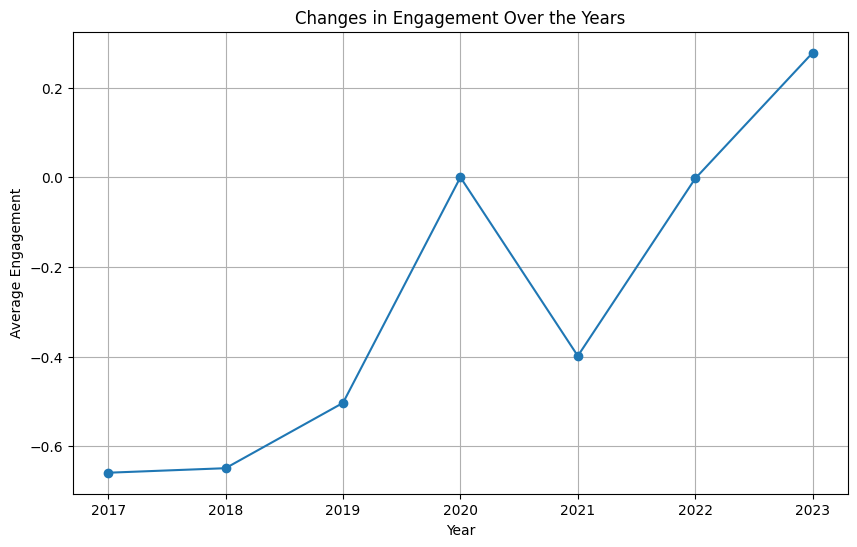

In [29]:
# Check that 'Engagement' is a column in the DataFrame
# avoiding errors
if 'Engagement' in final_df.columns:
    
    # Group by year and calculate the mean of the PCA component for each year.
    yearly_engagement = final_df.groupby('year')['Engagement'].mean()
    
    # Plotting the changes in engagement over the years
    plt.figure(figsize=(10, 6))
    yearly_engagement.plot(kind='line', marker='o')
    plt.title('Changes in Engagement Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Average Engagement')
    plt.grid(True)
    plt.show()
else:
    print("'PC1' column does not exist in the DataFrame.")

In [30]:
# checking the clusters
print(final_df['Cluster'].unique())

[1 0]


In [31]:
# dynamic string with value counts
print(f"""\
 -----------
| Cluster 0 |
 -----------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '0']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[ 0 , :].to_string(dtype = False, name = False)}


Year
----
{final_df.loc[final_df['Cluster'] == 0, 'year']
         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(index = False)}
  
  
Is Photo
--------
{final_df.loc[final_df['Cluster'] == 0, 'is_photo']
         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(index = False)}
""")

 -----------
| Cluster 0 |
 -----------

Proportion of Observations
--------------------------
0.0


Centroids
---------
Engagement    1.18
Reacts        2.65


Year
----
year
0.04
0.52
0.06
0.03
0.35
  
  
Is Photo
--------
is_photo
0.54
0.46



In [32]:
# dynamic string with value counts
print(f"""\
 -----------
| Cluster 1 |
 -----------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '1']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[ 1 , :].to_string(dtype = False, name = False)}


Year
----
{final_df.loc[final_df['Cluster'] == 1, 'year']
         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(index = False)}
  
  
Is Photo
--------
{final_df.loc[final_df['Cluster'] == 1, 'is_photo']
         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(index = False)}
""")

 -----------
| Cluster 1 |
 -----------

Proportion of Observations
--------------------------
0.0


Centroids
---------
Engagement   -0.08
Reacts       -0.19


Year
----
year
0.08
0.07
0.05
0.01
0.08
0.17
0.55
  
  
Is Photo
--------
is_photo
0.38
0.62



<h2>Linear Regression</h2>

<h3>Model 1: Original x-features</h3>

In [33]:
# choosing x_features
fb_features = facebook[ ['num_comments', 'num_shares', 'num_likes', 'num_loves', 
                         'num_wows', 'num_hahas', 'num_sads', 'num_angrys'] ]

In [34]:
# selecting x- and y-data
x_data = fb_features
y_data = final_df['is_photo']


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [35]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")


Train-Test Gap: 0.017
Test AUC Score: 0.678



In [36]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 92
False Positives: 138
False Negatives: 16
True Positives : 345



<h3>Model 2: Retained principal components</h3>

In [37]:
# selecting x- and y-data
x_data = fb_pca
y_data = final_df['is_photo']


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [38]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")


Train-Test Gap: 0.014
Test AUC Score: 0.678



In [39]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 91
False Positives: 139
False Negatives: 14
True Positives : 347



<h3>Model 3: Retained clusters</h3>

In [40]:
# factorizing cluster results 
cluster_df = pd.get_dummies(data       = fb_kmeans_pca['Cluster'],
                            drop_first = True).astype(dtype = int)


# checking results
cluster_df.value_counts(normalize = False).sort_index(ascending = False)

1
1    2206
0     156
Name: count, dtype: int64

In [41]:
# selecting x- and y-data
x_data = cluster_df
y_data = final_df['is_photo']


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [42]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true  = y_test,
                            y_score = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {round(roc_score, ndigits = 3)}
""")


Train-Test Gap: 0.0
Test AUC Score: 0.522



In [43]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 22
False Positives: 208
False Negatives: 19
True Positives : 342



<h2> Analysis of Best Model: Model 2</h2>

The Model 2 was chosen to be the best model for its stability and prediction, since it has Train-Test Gap of 0.014. This performs for a task where even a slight improvement in AUC is crucial. The higher AUC Score indicates that, on the test set, it is slightly more accurate at ranking positive instances higher than negative ones. This indicate that the model will perform reliably in production or on future data. This shows very little overfitting and may perform more consistently across different datasets. It suggests that the model performs almost equally well on both the training data and the unseen test data. Their difference in AUC is very little. This shows that it is marginally better at distinguishing between the classes than the first model.


True Negatives: The model correctly predicted 91 instances as negative. This shows the model's accuracy in identifying the negative class.
False Positives: The model incorrectly predicted 139 instances as positive that are actually negative. These are Type I errors and represent instances where the model predicted the outcome incorrectly as positive.
False Negatives: The model incorrectly predicted 14 instances as negative that are actually positive. These are Type II errors and represent instances where the model failed to identify the positive outcome.
True Positives: The model correctly predicted 347 instances as positive. This indicates the cases where the model's prediction was accurate for the positive class.

The model has a high number of True Positives compared to False Negatives, suggesting it has high sensitivity or recall. It is good at capturing the positive class and not missing out on many positive cases. There are more False Positives than True Negatives, the specificity of the model may be a concern, since the model incorrectly flags many negatives as positives. The model's precision is the proportion of positive identifications that were actually correct. The large number of false positives could lower the overall accuracy. False positives might lead to wasted resources. This could mean targeting users who are not interested in the product, no revenue will be earned. The low number of False Negatives is a good sign. This may overpredict the positive class given the high number of false positives.



References:

Bharadwaj, A., Chaudhary, A., Kittikachorn, P., & Rastogi, V. (2017). Five consumer trends to watch in Thailand. BCG Global. https://www.bcg.com/publications/2017/globalization-go-to-markets-five-consumer-trends-watch-thailand 

Facebook live shopping: A guide to boosting Ecommerce sales. BigCommerce. (n.d.). https://www.bigcommerce.com/articles/omnichannel-retail/facebook-live-shopping/ 

How Facebook distributes content. Facebook. (n.d.). https://www.facebook.com/business/help/718033381901819?id=208060977200861 

How images boost engagement on facebook. McAllister Marketing. (2017). https://mcallistermarketing.com/images-boost-engagement-facebook/ 

Lang, K. (2023). Decoding the Facebook Algorithm in 2024: Everything You Need to Know. Buffer. https://buffer.com/library/facebook-news-feed-algorithm/ 

Norcross, D. (2019). Social Media Trends 2019: Part 1 - facebook in Thailand. Lexicon. https://lexiconthai.com/blog/social-media-trends-2019-facebook-in-thailand/ 

Scorpio, A. (2023). Selling on Facebook: An Ecommerce Guide to Selling on Facebook Marketplace. ShipBob. https://www.shipbob.com/blog/selling-on-facebook/ 

Thailand ecommerce: A comprehensive look. ZhenHub. (2023). https://zhenhub.com/blog/thailand-ecommerce/ 

Thailand ecommerce Databook report 2023 explores accelerated growth, new Databook reveals in-depth market Kpis and consumer dynamics - forecasts to 2027 - researchandmarkets.com. Business Wire. (2024, February 5). https://www.businesswire.com/news/home/20240205023189/en/Thailand-Ecommerce-Databook-Report-2023-Explores-Accelerated-Growth-New-Databook-Reveals-In-Depth-Market-KPIs-and-Consumer-Dynamics---Forecasts-to-2027---ResearchAndMarkets.com 

